# Clase 25 - Interpretabilidad II 🧐

- MD
S7202: Laboratorio de Programación Científica para Ciencia de Datos
- Profesor: Ignacio Meza De la jara

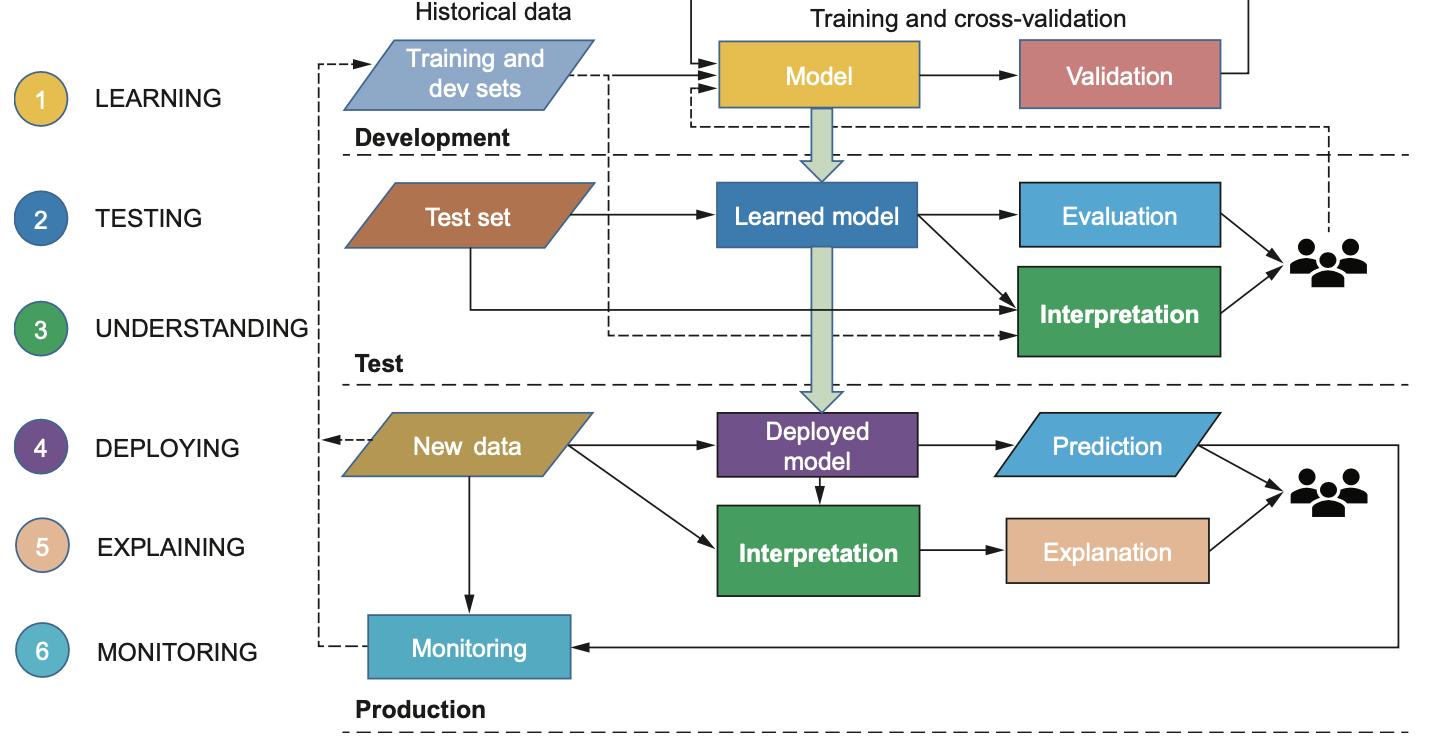

Objetivos:

- Comprender modelos agnosticos que permiten obtener explicaciones locales.
- Ver potenciales aplicaciones de Shap.

## Modelos Agnosticos Locales

Los métodos locales de interpretabilidad en machine learning (ML) se centran en explicar las predicciones de un modelo para un único punto de datos o un pequeño subconjunto de puntos de datos. Esto contrasta con los métodos globales, que intentan explicar las predicciones del modelo para todo el conjunto de datos.

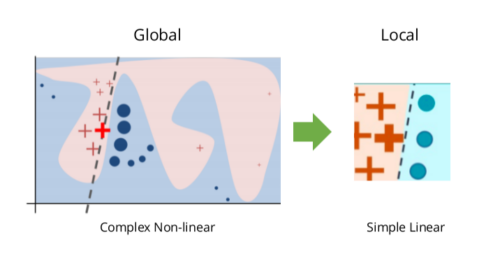

Los métodos locales suelen utilizarse cuando es importante entender por qué un modelo ha hecho una predicción concreta para un punto de datos específico. Por ejemplo, un médico podría querer entender por qué a un paciente se le diagnosticó una enfermedad concreta, o un analista financiero podría querer entender por qué el precio de una acción subió o bajó.

**Es importante** tener en cuenta que estos métodos son sólo aproximaciones a las verdaderas razones de las predicciones de un modelo. Además, los métodos locales pueden ser costosos desde el punto de vista informático y es posible que no puedan explicar las predicciones de todos los modelos.

### Tipos de métodos locales

**Modelos sustitutos locales**: Estos métodos crean un modelo simple e interpretable que se aproxima a las predicciones de un modelo complejo para un único punto de datos. Esto puede hacerse encontrando un modelo lineal que se aproxime a las predicciones del modelo de caja negra para el punto de datos.

**Importancia local de las características**: Estos métodos calculan la importancia de cada característica en el modelo para un único punto de datos. Esto puede hacerse midiendo cuánto cambia la predicción cuando se modifica la característica.

## Scoped Rules (Anchors)

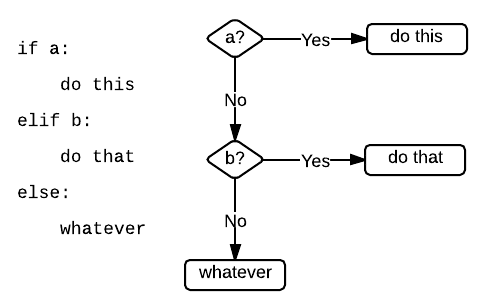

Las reglas de alcance, también conocidas como anchors (anclas en español), son un tipo de método de interpretabilidad local que explica las predicciones de un modelo para un único punto de datos. Los anclajes se crean encontrando reglas de decisión que "anclen" suficientemente la predicción. Una regla ancla una predicción si los cambios en los valores de otras características no afectan a la predicción.

### ¿Como funciona?

Los anclajes se crean mediante un algoritmo de aprendizaje por reinforcement-learning multi-armed bandit. El algoritmo empieza generando aleatoriamente un gran número de reglas. A continuación, el algoritmo evalúa cada regla prediciendo la etiqueta del punto de datos utilizando el modelo y la regla. El algoritmo se queda con las reglas que tienen la mayor precisión de predicción.

Finalmente, el algoritmo repite el proceso, pero esta vez sólo tiene en cuenta las reglas que se mantuvieron en la ronda anterior. El algoritmo sigue repitiendo este proceso hasta que encuentra un conjunto de reglas que anclan suficientemente la predicción.

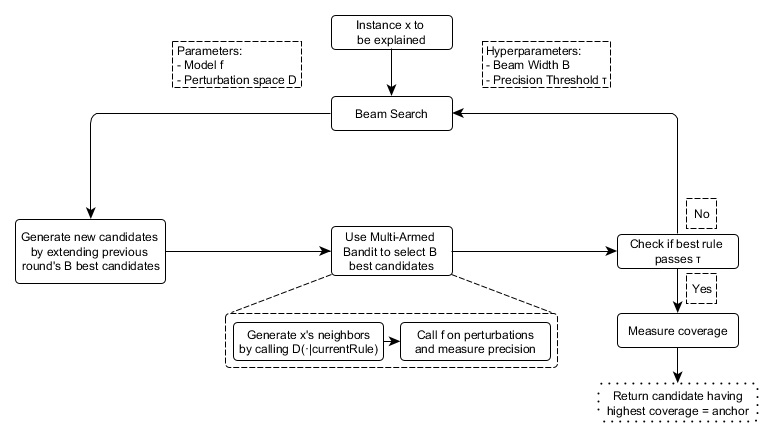

### Ejemplo

| Feature           | Valor  |
|-------------------|--------|
| Sexo              | M      |
| dinero_depositado | 30M    |
| Raza              | Asian  |
| ...               | ...    |
| Target            | Fraude |

*IF SEXO = M AND Raza = Asian AND dinero_depositado >= 20M THEN PREDICT Target = Fraude WITH PRECI- SION 97% AND COVERAGE 15%*

### ¿Coverage y Precision?

**El Coverage** (o cobertura) en las Anchors se refiere a la proporción de puntos de datos de un conjunto de datos que se explican por un anchor. El coverage de una anchor es importante porque indica hasta qué punto el anchor puede explicar las predicciones del modelo para otros puntos de datos.

Una anchor de alta cobertura tiene más probabilidades de ser útil para comprender las predicciones del modelo. **Un anchor de baja cobertura puede ser menos útil porque puede que sólo explique las predicciones del modelo para un pequeño número de puntos de datos**.

La cobertura de un ancla puede calcularse dividiendo el número de puntos de datos que explica la anchor, por el número total de puntos de datos del conjunto de datos. Por ejemplo, si una anchor explica 100 puntos de datos en un conjunto de datos de 1000 puntos de datos, la cobertura del ancla es del 10%.

**La cobertura de un anclaje puede verse afectada por varios factores**, como el tamaño del conjunto de datos, la complejidad del modelo y el número de reglas del anclaje. En general, los conjuntos de datos más grandes, los modelos más sencillos y un menor número de reglas darán lugar a anclas de mayor cobertura.

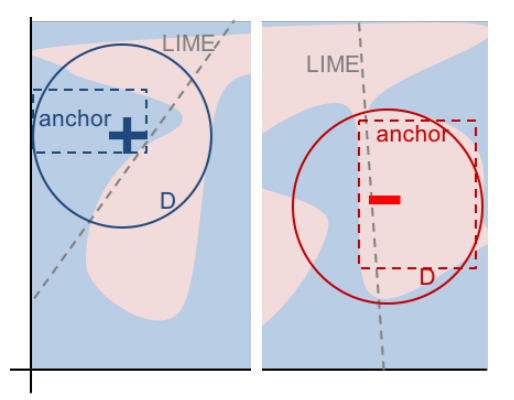

La **precisión** de una anchor es la fracción de puntos de datos que la anchor explica correctamente. **Una anchor con alta precisión tiene más probabilidades de ser exacta y útil para comprender las predicciones del modelo**.

La precisión puede calcularse dividiendo el número de puntos de datos explicados correctamente por la anchor entre el número total de puntos de datos explicados por el anclaje. Por ejemplo, si una anchor explica correctamente 100 puntos de datos de los 1.000 que explica, la precisión del anchor es del 10%.

### Consideraciones

Si el conjunto de entrenamiento está desbalanceado, el espacio de perturbación también lo está. Esta condición afecta a la búsqueda de reglas y a la precisión que podrían tener los resultados.

### Ventajas
- Facil de interpretar.
- Funciona cuando las predicciones del modelo no son lineales o son complejas en la vecindad de una instancia.
- Es altamente eficiente y puede ser paralelizado el proceso de busqueda de interpretabilida. (en el papel)

### Desventajas
- Aveces necesita un ajuste de sus parámetros para entregar buenos resultados.
- Muchos escenarios requieren una discretización, ya que de lo contrario los resultados son demasiado específicos, tienen poca cobertura y no contribuyen a la comprensión del modelo.
- Tiene muchas llamadas al modelo de ML entrenado.
- La cobertura no esta bien definida en algunos dominios (especificamente en imagenes).

### Ejemplo en Python

In [354]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from alibi.explainers import AnchorTabular
from alibi.datasets import fetch_adult

import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler

In [355]:
path = "/Users/imezadelajara/Repositories/MDS7202/recursos/2023-01/25_interpretacion_II/credit_risk.csv"
df = pd.read_csv(path, index_col="Unnamed: 0")

In [356]:
df.head(4)

,balance_avg_3m_avg_trunc,balance_avg_trunc,balance_last_amount_trunc,balance_avg_lag_1m_trunc,balance_avg_3m_avg,balance_last_amount_avg_3m_trunc,contacts_p_macher_used_virtual_international_last_1m,contacts_p_macher_used_cash_in_last_3m,balance_avg_lag_2m_trunc,cash_in_sum_amount,...,family_mother_age,contacts_p_macher_used_bill_payments_last_1m,family_father_age,bill_payments_avg_3m_sum_amount,family_q,family_max_age_children_between_5_12,user,target_value,year,month
0,99.681818,205.50000,0.0,93.545455,-8102.750216,0.0,1.651298,1.832601,0.000000,29652.0,...,50.067204,2.576881,-9999.000000,-9999.0,1,-9999.0,6961698a-d855-4634-b05b-593a4d903834,0.0,2022,9
1,7274.507971,15729.20000,0.0,5926.173913,-37824.964493,0.0,1.268770,1.477694,168.150000,678800.0,...,55.309140,4.461335,58.741935,-9999.0,5,-9999.0,df1cd2ae-3cb5-44fb-9d5b-c6ee0018915e,0.0,2022,4
2,1298.723464,2535.26087,27465.0,837.100000,-3316.767012,9155.0,1.002798,1.140024,523.809524,55600.0,...,63.435484,0.882195,69.424731,-9999.0,4,-9999.0,e10f2f51-3872-4d7f-8e07-3e5cc2d7fd56,1.0,2022,3
3,2187.955051,2631.35000,0.0,637.181818,-11891.366378,2755.0,-9999.000000,-9999.000000,3295.333333,86763.0,...,-9999.000000,-9999.000000,66.822581,0.0,4,-9999.0,6bcaecce-26ed-4dde-9b32-e3af2d58e04d,0.0,2022,9


In [379]:
X = df[df.columns[0:10]] #.drop(columns=['user', 'target_value', 'year', 'month'])
y = df['target_value']

#rus = RandomUnderSampler(random_state=0)
#X_resampled, y_resampled = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y)

In [380]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [381]:
preds = clf.predict(X_test)
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.96      0.82      0.89      4272
           1       0.12      0.43      0.19       252

    accuracy                           0.80      4524
   macro avg       0.54      0.63      0.54      4524
weighted avg       0.91      0.80      0.85      4524



In [382]:
predict_fn = lambda x: clf.predict(x)
explainer = AnchorTabular(predict_fn, clf.feature_names_in_, seed=1)
explainer.fit(X_train.to_numpy())

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': 1, 'disc_perc': (25, 50, 75)},
  'version': '0.9.2'}
)

In [383]:
explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]

0

In [384]:
idx = 12

class_names = ["cliente_pagador", "cliente_deudor"]
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])

Prediction:  cliente_deudor


In [385]:
idx = 11
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  cliente_pagador
Anchor: contacts_p_macher_used_cash_in_last_3m > 1.23
Precision: 0.96
Coverage: 0.50


In [363]:
idx = 0
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  cliente_pagador
Anchor: contacts_p_macher_used_cash_in_last_3m > 1.04 AND balance_avg_trunc > 156.55 AND contacts_p_macher_used_virtual_international_last_1m <= 1.60 AND balance_avg_3m_avg <= -18625.48
Precision: 0.99
Coverage: 0.07


## Shap

![](https://shap.readthedocs.io/en/latest/_images/shap_header.png)

Propuesto en 2017 por Lundberg y Lee, esté es uno de los métodos más utilizados actualmente en la industría (reemplazo directo de LIME).



El método de las explicaciones aditivas de Shapley (SHAP) es un enfoque teórico de juegos para explicar el resultado de un modelo de aprendizaje automático. Funciona considerando todas las posibles coaliciones de características y asignando a cada característica un valor de Shapley, que mide la contribución de esa característica al resultado del modelo.

Una innovación que aporta SHAP es que la explicación del valor de Shapley se representa como un método aditivo de atribución de características, un modelo lineal:

$$g(z')=\phi_0 + \sum_{j=1}^M \phi_j z'_j$$

Dentro de las propiedades que posee shap podemos encontrar 3:

- Precisión local: los valores SHAP son localmente precisos, lo que significa que son precisos para una predicción concreta. Esto contrasta con las medidas de importancia de características globales, como la importancia de permutación, que son precisas para todo el conjunto de datos.

$$\hat{f}(x)=g(x´)=\phi_0 + \sum_{j=1}^M \phi_j x'_j$$

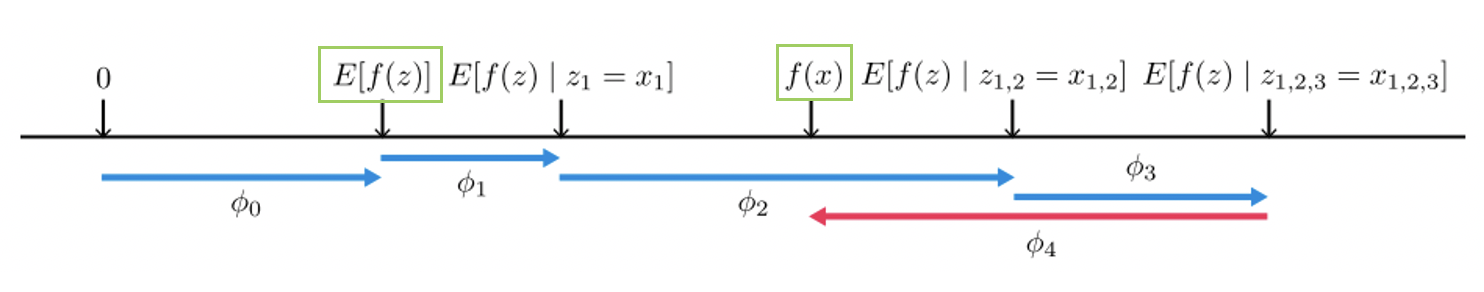

- Missigness: Los valores SHAP son capaces de explicar las predicciones de los modelos incluso cuando faltan características. Esto se debe a que los valores SHAP se calculan utilizando una representación lineal de las características, lo que les permite tener en cuenta los valores que faltan.

$$x_j'=0 \rightarrow \phi_j=0$$

- Consistencia: La propiedad de coherencia dice que si un modelo cambia de modo que la contribución marginal del valor de una característica aumenta o se mantiene igual (independientemente de otras características), el valor de Shapley también aumenta o se mantiene igual.

En otras palabras:

$$\phi_j(\hat{f´}, x) \geq \phi_j(\hat{f}, x)$$

Si dos modelos $f$ y $f'$ cumple:
$$\hat{f´}_x(z´) - \hat{f´}_x(z_j´) \geq \hat{f}_x(z´) - \hat{f}_x(z_j´)$$

        ❓ Pregunta: ¿Un ejemplo de esto?


<img src="https://gastronomiaycia.republica.com/wp-content/uploads/2021/05/truco_pinzasensalada_tarta2.jpg" width="250">

### Kernel y como funciona

El núcleo Shap es un método para calcular los valores SHAP que nace bajo la necesidad de optimizar el calculo de los Shapley values. Para esto se utiliza el valor shapley de una característica, la cual es una medida de la contribución de esa característica al resultado de un modelo de aprendizaje automático.

La función kernel es una función que determina cómo se combinan las contribuciones de las distintas características. La función kernel más común es el kernel lineal, que simplemente suma las contribuciones de diferentes características. Sin embargo, se pueden utilizar otras funciones, como el kernel gaussiano, que da más peso a las características que son similares entre sí.

**Importante**: El kernel Shap es una forma más eficaz de calcular los valores SHAP que el método original de los valores Shapley. También es más resistente al ruido en los datos.

El kernel Shap se calcula siguiendo los siguientes pasos:

1. Inicializar el kernel Shap a cero.

    Para cada característica:
    1. Considere todas las posibles coaliciones de características que incluyan la característica actual.
    2. Calcule la contribución de la característica actual a cada coalición.
    3. Multiplicar la contribución de la característica actual por la función del kernel.
    4. Añadir la contribución de la característica actual al kernel Shap.
    5. Normalizar el kernel Shap para que sume uno.

De los pasos dos puntos importantes son las siguientes ecuaciones:

$$\pi_x(z') = \dfrac{\text{N de features}-1}{(cantidad \, de \, coaliciones \, de  \, tamaño \, C)*(N \, de \, features \, en \, C)*(N \, de \, features \, no \, incluidas \, en \, C)}$$

$\pi_x$ es un vector propuesto en el paper que cumplirá con el rol de obtener los shapley values del problema y por ende se debe utilizar en la función de perdida utilizada para optimizar la regresión $g(z')$ 

$$L(\hat{f}, g, \pi_x)=\sum_{z' \in Z}[\hat{f}(h_x(z'))-g(z´)]\pi_x(z')$$

### Ventajas

- SHAP tiene una sólida base teórica en la teoría de juegos. 
- La predicción se distribuye equitativamente entre los valores de las características. 
- Obtenemos explicaciones contrastivas que comparan la predicción con la predicción media.
- SHAP dispone de una aplicación rápida para modelos basados en árboles.
- Su "rápida aplicación" permite generar explicaciones globales de los modelos.

### Desventajas

- El SHAP kernel tiende a ser lento cuando se tienen muchos datos.
- KernelSHAP ignora la dependencia de las características.
- TreeSHAP puede producir atribuciones de características poco intuitivas.

### Ejemplo en Python

In [199]:
import shap

In [202]:
X = df.drop(columns=['user', 'target_value', 'year', 'month'])
y = df['target_value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y)

In [203]:
# Head del conjunto de entrenamiento
X_train.head(5)

,balance_avg_3m_avg_trunc,balance_avg_trunc,balance_last_amount_trunc,balance_avg_lag_1m_trunc,balance_avg_3m_avg,balance_last_amount_avg_3m_trunc,contacts_p_macher_used_virtual_international_last_1m,contacts_p_macher_used_cash_in_last_3m,balance_avg_lag_2m_trunc,cash_in_sum_amount,...,contacts_p_macher_used_bill_payments_last_6m,contacts_p_macher_used_mach_pay_last_1m,idle_days_mach_pay,contacts_min_debt_score,family_mother_age,contacts_p_macher_used_bill_payments_last_1m,family_father_age,bill_payments_avg_3m_sum_amount,family_q,family_max_age_children_between_5_12
12862,195.136364,0.000000,0.0,0.000000,-11489.132616,0.000000,1.082677,1.164725,585.409091,3600.0,...,5.036941,1.343627,-9999,2,60.693548,0.0,62.682796,-9999.0,8,-9999.000000
11703,971.553030,1499.400000,3922.0,1330.409091,-3148.531818,8930.333333,0.735044,0.791305,84.850000,105337.0,...,0.897987,1.838623,173,2,62.631720,0.0,65.456989,-9999.0,8,11.454301
2785,6311.768116,3823.800000,0.0,11919.304348,-18892.139855,21066.666667,1.260890,1.116072,3192.200000,243000.0,...,1.160983,1.161926,364,2,-9999.000000,0.0,74.129032,-9999.0,5,-9999.000000
6420,5464.328070,16003.684211,35070.0,389.300000,-10341.588995,11690.000000,1.470302,1.128224,0.000000,81000.0,...,0.000000,0.000000,230,2,-9999.000000,0.0,-9999.000000,0.0,4,10.344086
3414,5861.531746,3023.500000,0.0,14561.095238,-15663.276190,0.000000,1.587376,1.466215,0.000000,168255.0,...,0.000000,0.000000,56,9,50.010753,0.0,-9999.000000,0.0,1,-9999.000000


In [204]:
# Dimensiones del dataframe
X_train.shape

(9185, 225)

In [205]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [206]:
preds = clf.predict(X_test)
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      4087
           1       0.42      0.85      0.56       437

    accuracy                           0.87      4524
   macro avg       0.70      0.86      0.75      4524
weighted avg       0.93      0.87      0.89      4524



Comencemos probando la interpretabilidad del modelo construido con los métodos que vienen por default: **weight**, **cover** y **gain**.

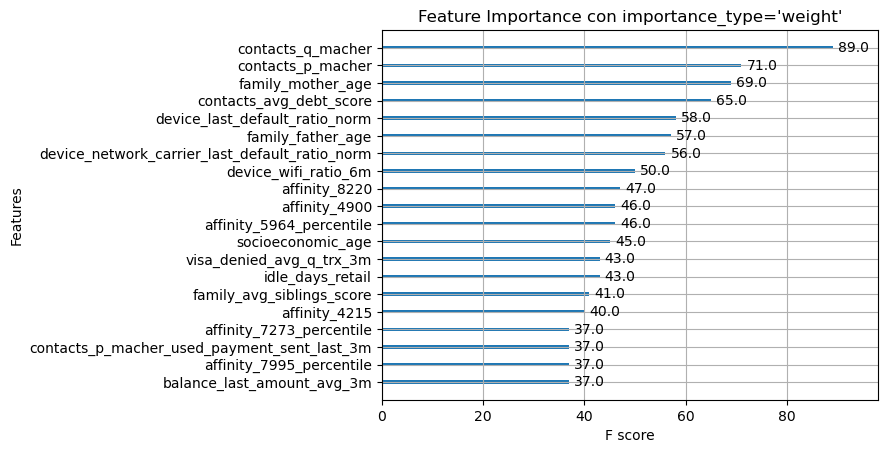

In [213]:
import xgboost as xgb

xgb.plot_importance(clf, max_num_features=20)
plt.title("Feature Importance con importance_type='weight'")
plt.show()

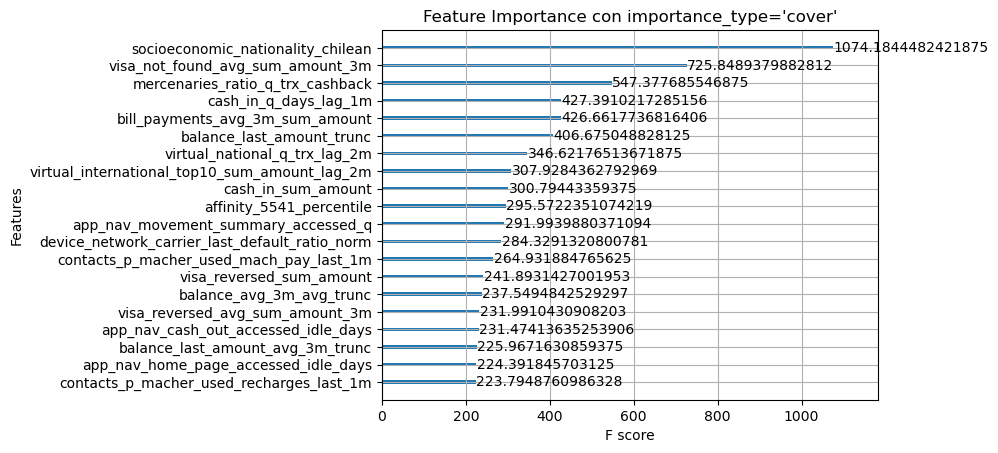

In [214]:
xgb.plot_importance(clf, max_num_features=20, importance_type="cover")
plt.title("Feature Importance con importance_type='cover'")
plt.show()

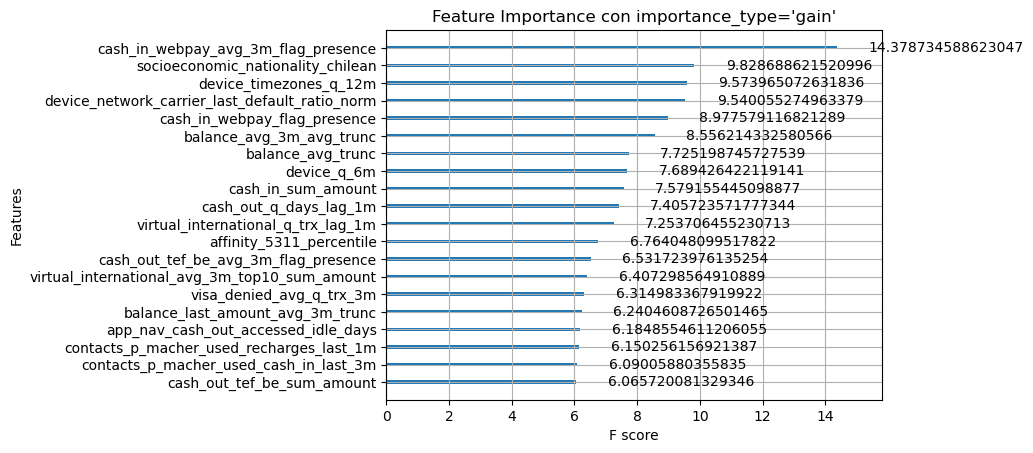

In [215]:
xgb.plot_importance(clf, max_num_features=20, importance_type="gain")
plt.title("Feature Importance con importance_type='gain'")
plt.show()

        ❓Pregunta: ¿Qué sucede con las importancias?

La importancia de XGBoost (y en general en modelos que utilizan árboles) se calcula en función del número de veces que se utiliza una característica para dividir un nodo en un árbol de decisión. Puede ser una medida útil de la importancia de una característica para la precisión global del modelo. Sin embargo, puede inducir a error en el caso de características con muchos valores posibles, ya que estas características pueden utilizarse con más frecuencia simplemente porque hay más oportunidades de dividirlas.

        ❓Pregunta: ¿Cómo se utiliza shap para calcular la importancia?

In [287]:
# Primero comenzamos eligiendo el explainer, este debe ser coherente con el problema
# que estamos resolviendo, para este caso como estamos usando boosting, usamos
# árboles
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


¿Qué incluye shap_values? - Con el explainer calcularemos los shap para cada uno de las instancias del modelo. 

In [302]:
shap_values

.values =
array([[ 0.21368541,  0.16251478, -0.00493488, ...,  0.0271268 ,
        -0.28736532, -0.02309125],
       [-0.01902836, -0.07259533,  0.01964378, ...,  0.01100624,
         0.02409805, -0.03020418],
       [ 0.0897951 , -0.23089282, -0.15519652, ...,  0.02684262,
         0.0559514 , -0.027842  ],
       ...,
       [-0.07551759, -0.1921459 ,  0.02880075, ...,  0.04070123,
        -0.03130298, -0.03011776],
       [ 0.09243104, -0.26356417,  0.02117708, ..., -0.33186567,
        -0.06322856, -0.02859445],
       [ 0.1758149 ,  0.1728219 ,  0.05770873, ...,  0.08973446,
        -0.0544889 ,  0.01049062]], dtype=float32)

.base_values =
array([-1.6966853, -1.6966853, -1.6966853, ..., -1.6966853, -1.6966853,
       -1.6966853], dtype=float32)

.data =
array([[ 9.96818182e+01,  2.05500000e+02,  0.00000000e+00, ...,
        -9.99900000e+03,  1.00000000e+00, -9.99900000e+03],
       [ 7.27450797e+03,  1.57292000e+04,  0.00000000e+00, ...,
        -9.99900000e+03,  5.00000000e+00, 

Uno de los valores relevantes que se calcula con el explainer es el **valor base**. El valor base es el valor esperado de la salida de un modelo de aprendizaje automático si no tuviera información sobre las características. Se calcula promediando las predicciones del modelo en un gran conjunto de datos de ejemplos. El valor base se utiliza como punto de referencia para comprender cómo contribuyen las características de un ejemplo concreto a la predicción del modelo para ese ejemplo.

**Ejemplo**: consideremos un modelo que predice el precio de una casa. El valor base de este modelo sería el precio medio de todas las casas del conjunto de datos. Si el modelo predice que una casa en particular vale 300.000 dólares, los valores SHAP mostrarían cómo contribuye cada característica de esa casa a la diferencia entre la predicción del modelo y el valor base.

**El valor base es importante para entender los valores SHAP porque proporciona un contexto para interpretar los valores**. Sin el valor base, sería difícil saber si un valor SHAP es positivo o negativo. Por ejemplo, un valor SHAP positivo podría significar que la característica aumenta la predicción del modelo, o podría significar que la característica disminuye la predicción del modelo en una cantidad menor que el valor base.

El valor base también es importante para comprender cómo interactúan las características entre sí. Por ejemplo, consideremos un modelo que predice el riesgo de que un paciente desarrolle cáncer. El valor base de este modelo sería el riesgo medio de todos los pacientes del conjunto de datos. Si el modelo predice que un paciente concreto tiene un riesgo del 10%, los valores SHAP mostrarían cómo contribuye cada característica de ese paciente a la diferencia entre la predicción del modelo y el valor base.


En especifico, si revisamos `shap_values.values`, podemos ver que esta posee la siguiente dimensión:

In [293]:
# Vemos el valor de la instancia x_1
shap_values.values[1,:].shape

(225,)

Tendremos un valor para cada una de las features con las que fue entrenado el modelo.

In [294]:
shap_values.values[1,:]

array([-1.90283600e-02, -7.25953281e-02,  1.96437836e-02,  7.30825169e-03,
        4.94846143e-02,  1.37321698e-02,  9.95898172e-02, -1.25373214e-01,
        4.46209237e-02, -1.40505567e-01, -1.48545876e-02, -1.26923338e-01,
       -1.39901742e-01,  4.86886129e-03,  7.75829796e-03,  1.27928169e-03,
       -4.49715219e-02, -7.87122771e-02,  2.66689956e-02, -3.34851211e-05,
        7.18917996e-02, -1.53330445e-01, -2.08474752e-02,  8.35970882e-03,
        8.95939954e-03, -1.08943963e-02, -3.87637988e-02, -9.20239836e-02,
       -9.59477276e-02, -5.74776419e-02, -1.42930355e-02,  5.26084155e-02,
       -2.74613015e-02, -6.54789954e-02, -5.45321926e-02, -9.29360762e-02,
       -6.10473640e-02, -1.10315293e-01, -1.21414866e-02, -3.34079145e-04,
        8.91643167e-02,  1.27644241e-02,  1.07316487e-02,  3.83763686e-02,
       -2.35195048e-02,  1.09174922e-02,  1.09531153e-02,  9.14787594e-03,
        1.17926009e-01,  4.84432131e-02,  1.25746941e-04,  0.00000000e+00,
        5.92346117e-02,  

Los valores negativos señalan aportes negativos para detectar el target de interés que en este caso es la morosidad de los clientes a tres meses. Por otro lado, los positivos señalan variables que entregan un aporte positivo a la detección de la label 1 (morosidad a 3 meses).

Para ver los aportes de las diferentes variables utilizando shap se realiza lo siguiente:

In [297]:
idx = 1

shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values.values[idx,:], 
                X.iloc[idx,:],
                link="logit")

Notar que `link="logit"` se encargará de entregar una probabilidad en la salida. Por otro lado, de esta forma es mucho más simple visualizar los aportes de cada una de las variables para tomar la decisión en el output.

Veamos un segundo ejemplo:

In [298]:
idx = 2

shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values.values[idx,:], 
                X.iloc[idx,:],
                link="logit")

Una forma más intuitiva de generar este tipo de gráficos es de la siguiente forma:

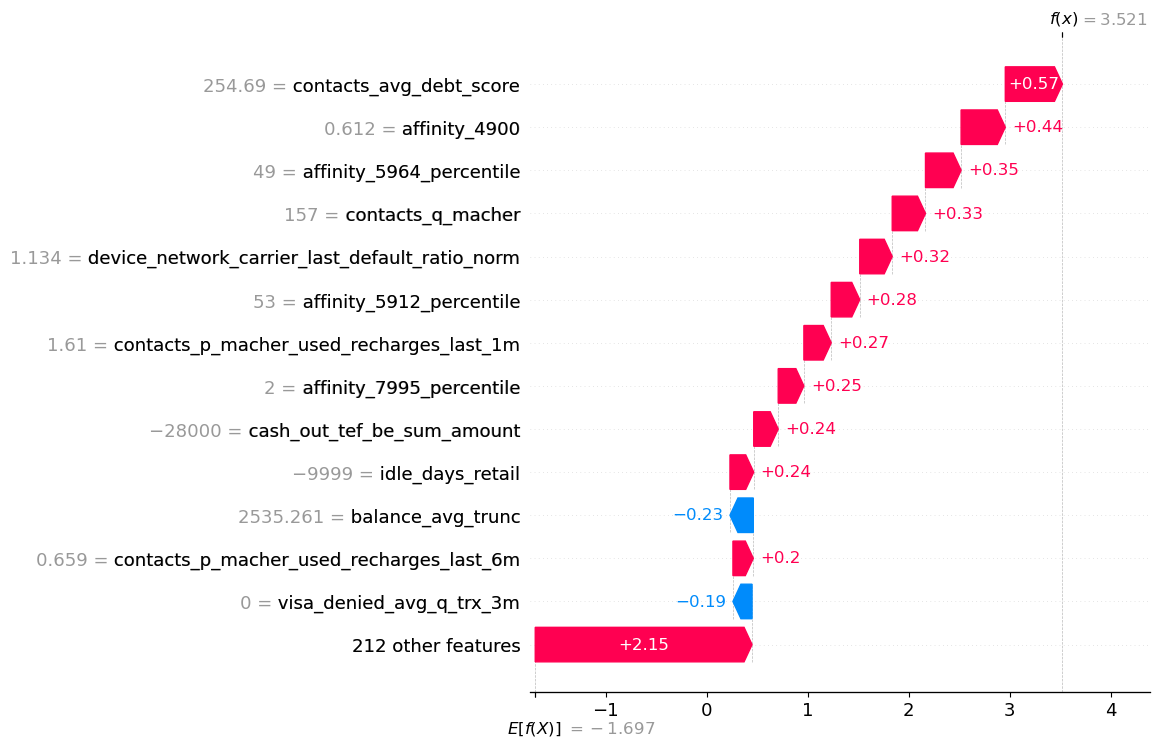

In [386]:
idx=2
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

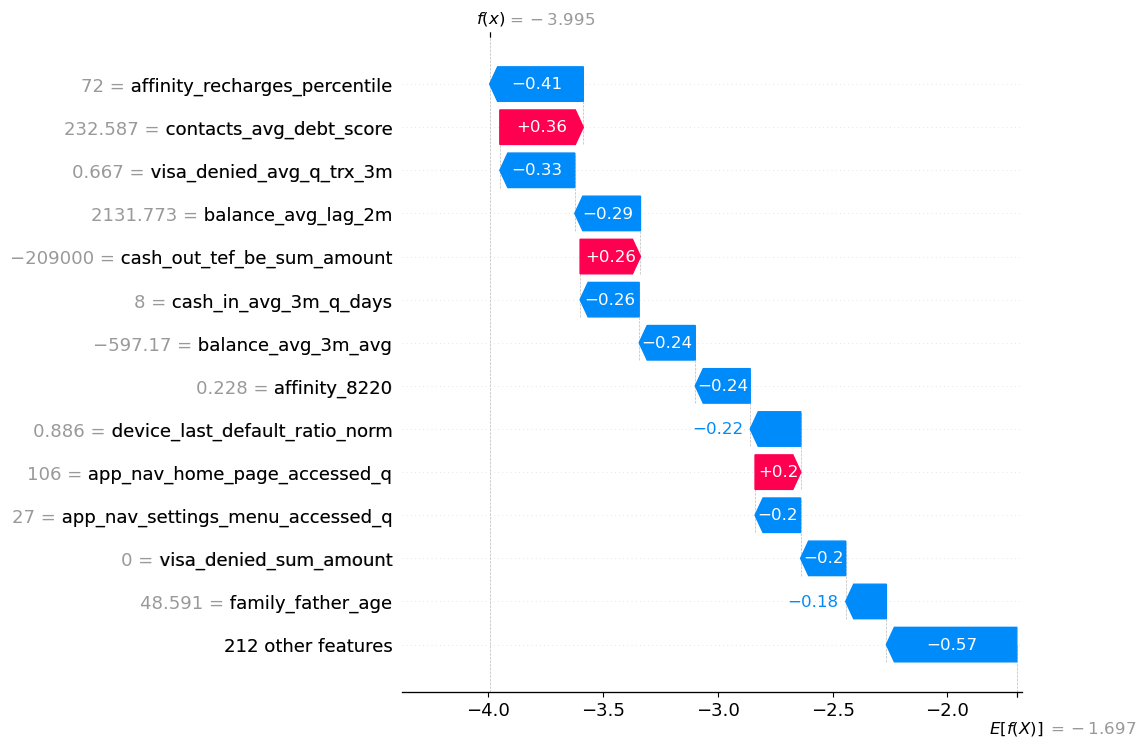

In [387]:
idx=23
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

Otra forma de hacer esto es con un batch de datos, para esto realizamos lo siguiente:

In [239]:
shap.force_plot(explainer.expected_value, shap_values[:5,:], X.iloc[:5,:], link='logit')

Otra forma de hacer esto es realizando un mapa de calor...

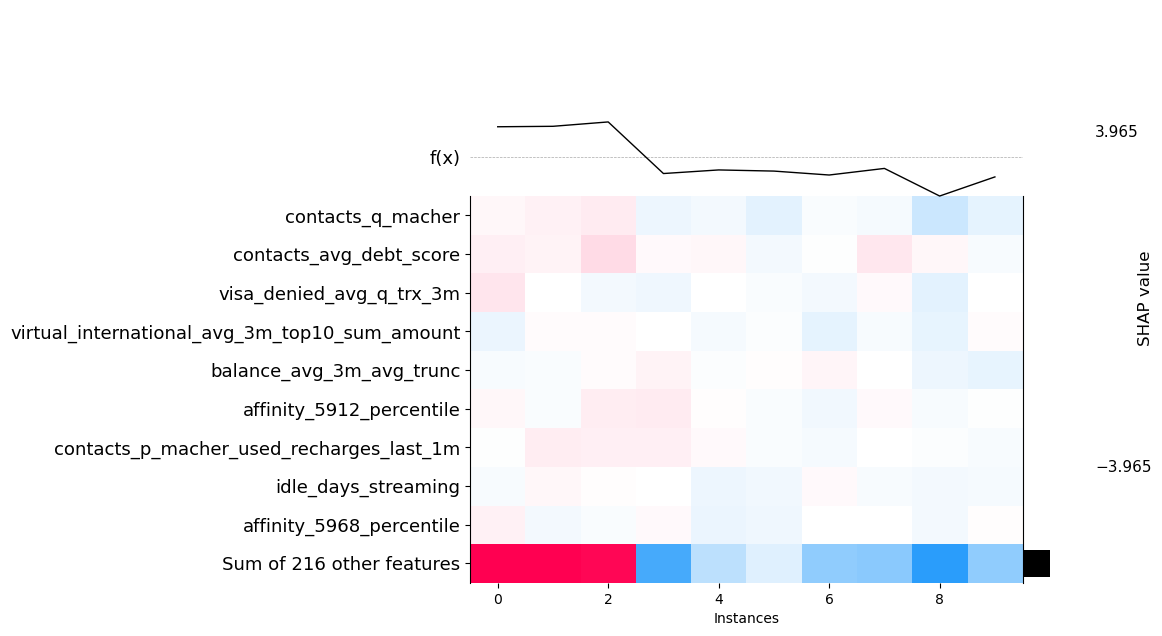

In [389]:
shap.plots.heatmap(shap_values[:10])

¿Que pasa si quiero obtener la interpretabilidad global?

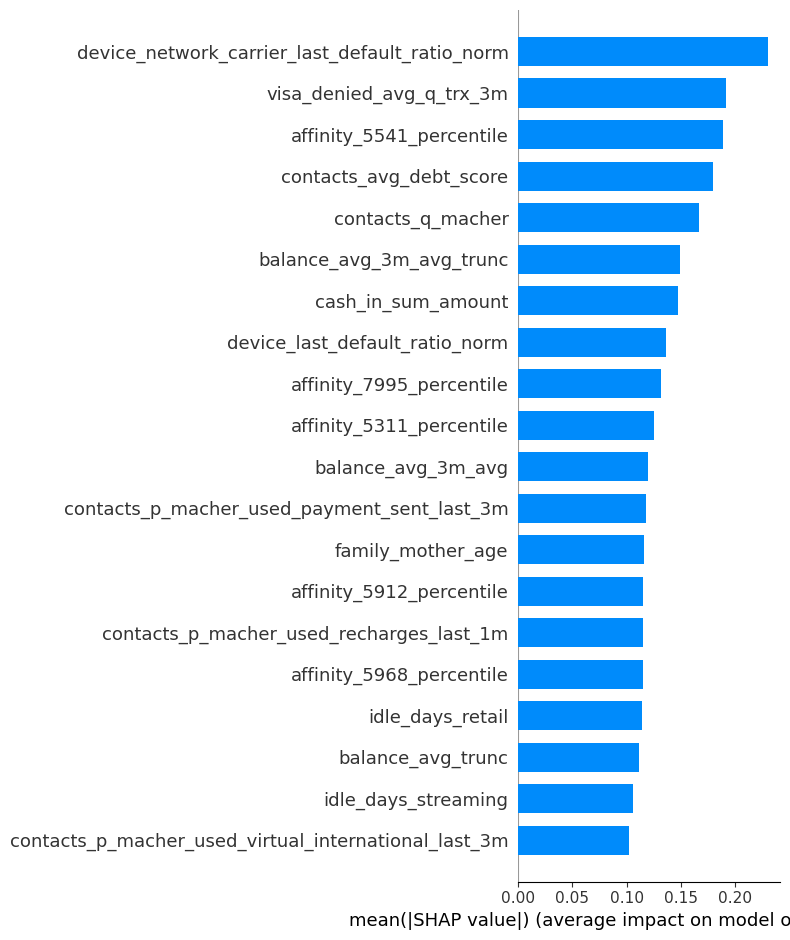

In [240]:
shap.summary_plot(shap_values, X, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


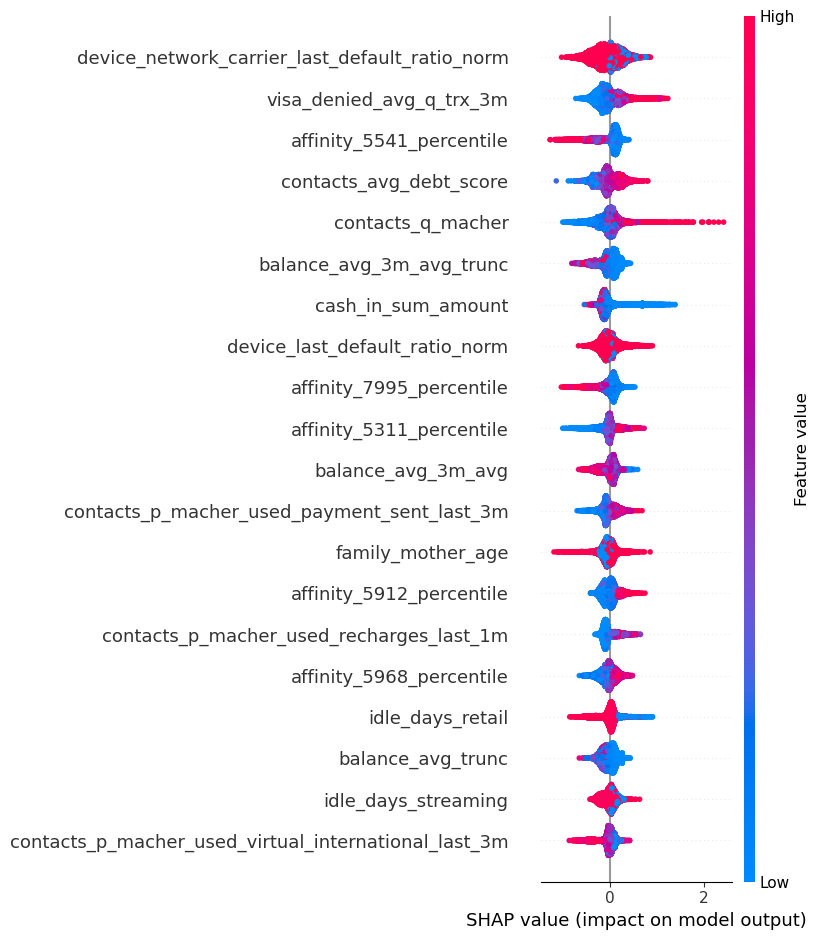

In [241]:
# Otra forma der ver el plot anterior es la siguiente
shap.summary_plot(shap_values, X)

¿Qué pasa si necesitamos obtener las variables más importantes en orden?

In [304]:
# obtenemos los shap values
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

# Obtenemos los nombres ordenados de mayor a menor
feature_importance_names = X_train.columns[shap_values_abs.argsort()[::-1]]

In [305]:
# Revisamos las features
feature_importance_names

Index(['device_network_carrier_last_default_ratio_norm',
       'visa_denied_avg_q_trx_3m', 'affinity_5541_percentile',
       'contacts_avg_debt_score', 'contacts_q_macher',
       'balance_avg_3m_avg_trunc', 'cash_in_sum_amount',
       'device_last_default_ratio_norm', 'affinity_7995_percentile',
       'affinity_5311_percentile',
       ...
       'app_nav_mach_card_delivery_error_q',
       'app_nav_junior_information_added_q', 'cash_out_tef_be_flag_presence',
       'app_nav_invitation_sent_q', 'app_nav_invitation_page_accessed_q',
       'app_nav_debt_request_error_q', 'app_nav_custom_qr_flow_started_q',
       'app_nav_qr_scan_cam_opened_q', 'app_nav_bip_card_number_saved_q',
       'app_nav_request_link_menu_accessed_q'],
      dtype='object', length=225)

In [390]:
feature_importance_names[:20]

Index(['device_network_carrier_last_default_ratio_norm',
       'visa_denied_avg_q_trx_3m', 'affinity_5541_percentile',
       'contacts_avg_debt_score', 'contacts_q_macher',
       'balance_avg_3m_avg_trunc', 'cash_in_sum_amount',
       'device_last_default_ratio_norm', 'affinity_7995_percentile',
       'affinity_5311_percentile', 'balance_avg_3m_avg',
       'contacts_p_macher_used_payment_sent_last_3m', 'family_mother_age',
       'affinity_5912_percentile', 'contacts_p_macher_used_recharges_last_1m',
       'affinity_5968_percentile', 'idle_days_retail', 'balance_avg_trunc',
       'idle_days_streaming',
       'contacts_p_macher_used_virtual_international_last_3m'],
      dtype='object')

Por otra parte, uno de los gráficos más interesantes es plotear la relación de los shap v/s las features entrantes del modelo.

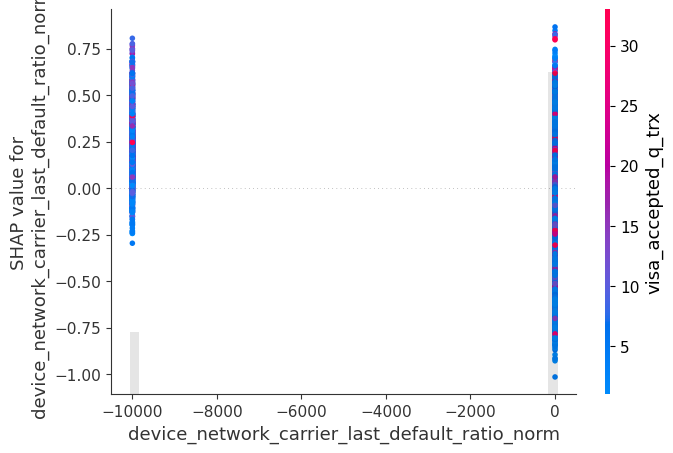

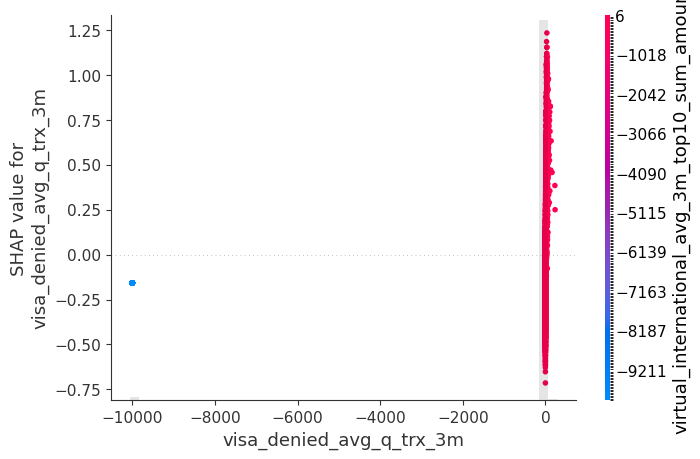

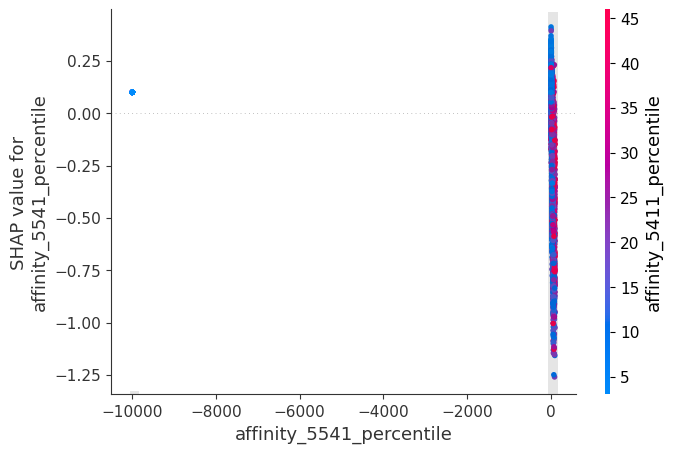

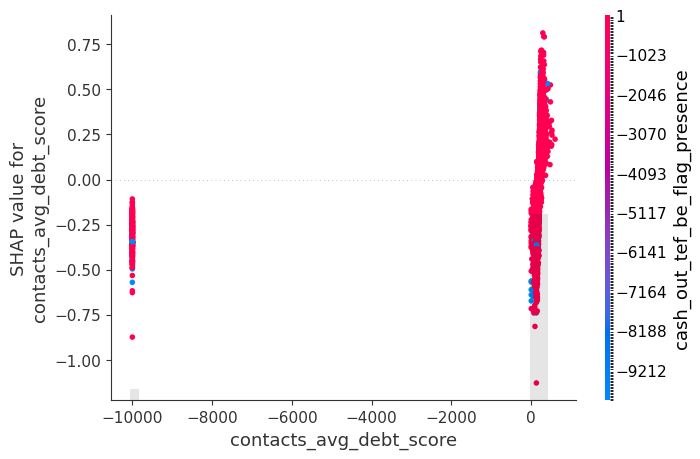

In [327]:
for name in feature_importance_names[:4]:
    #shap.dependence_plot(name, shap_values.values, X)
    shap.plots.scatter(shap_values[:,name], 
                   color=shap_values)

Tenemos un problema con estos gráficos... Los valores extremos que presentan impiden visualizar el comportamiento de valores superiores a cero.

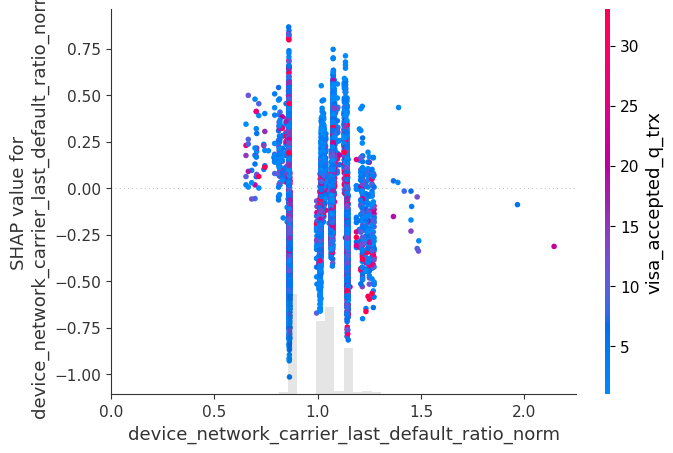

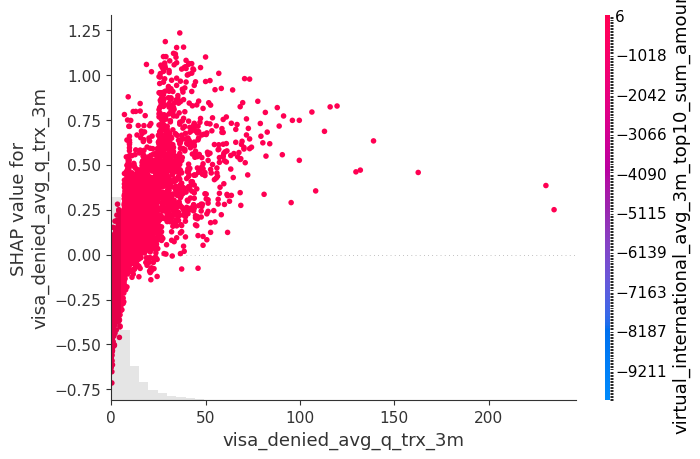

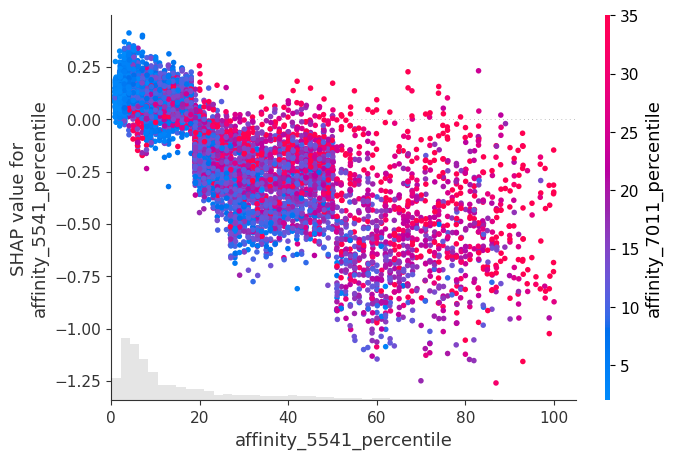

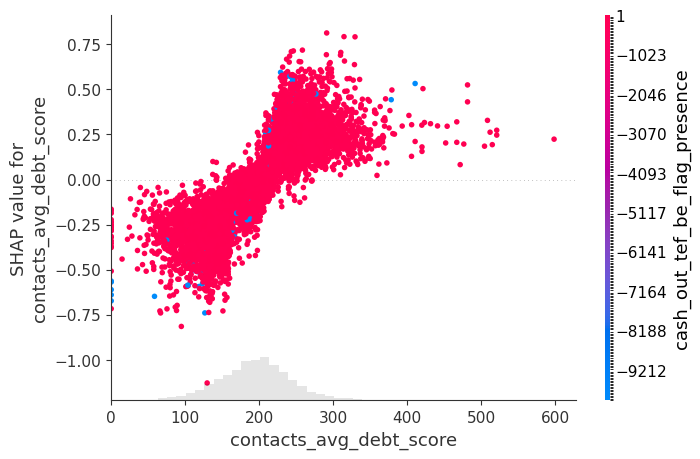

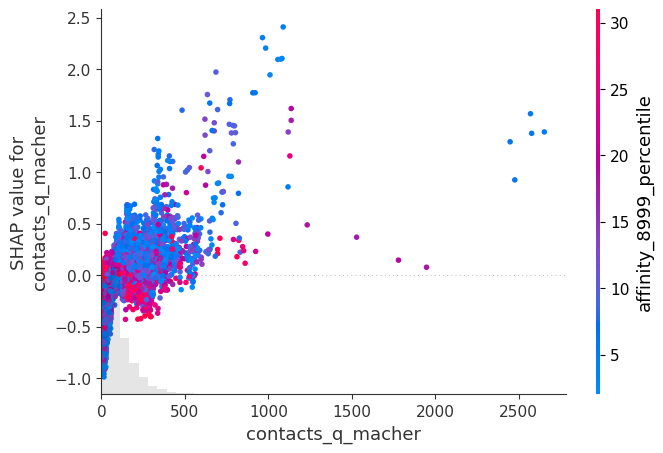

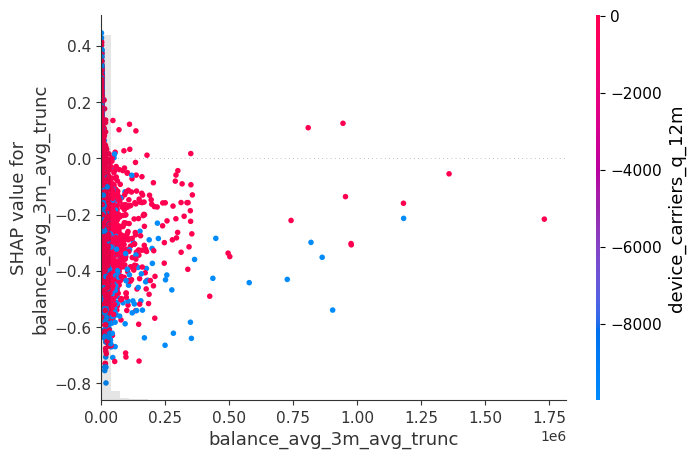

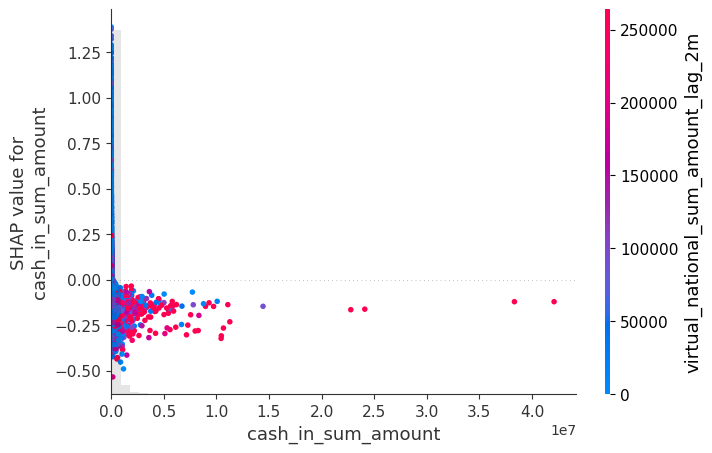

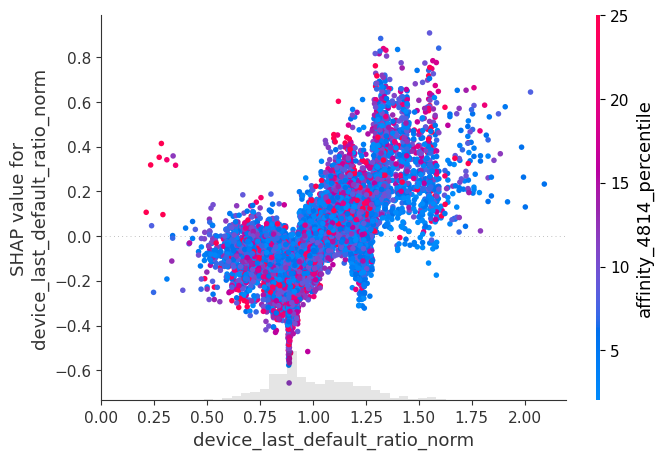

In [334]:
for name in feature_importance_names[:8]:
    #shap.dependence_plot(name, shap_values.values, X)
    shap.plots.scatter(shap_values[:,name], 
                       color=shap_values, xmin=0)    

### PDP (¿denuevo?)

Punto interesante... Shap puede calcular las PDP de las variables 😃, o sea... es un reemplazante directo de gran parte de los métodos que vimos:

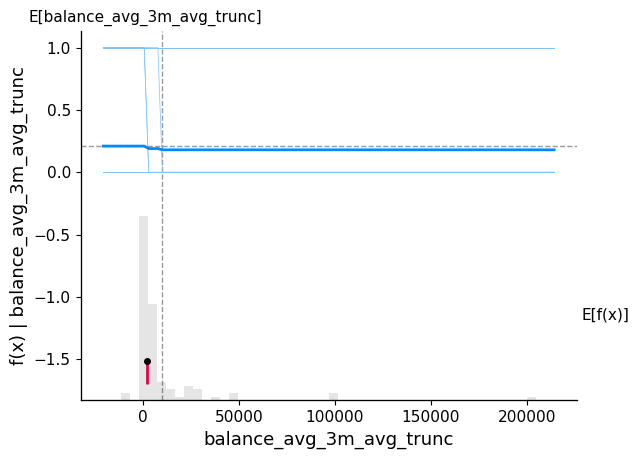

In [326]:
X100 = shap.utils.sample(X, 100)

sample_ind = 20
shap.partial_dependence_plot(
    'balance_avg_3m_avg_trunc', clf.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=True,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)